## **Data Understanding**

In [1]:
import pandas as pd
import numpy as np

from pycaret.time_series import *

import matplotlib.pyplot as plt

import warnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

ModuleNotFoundError: No module named 'pycaret'

In [2]:
dataset = pd.read_csv('./dataset/data NO2/hasil-data.csv')

In [3]:
display(dataset)

,t,x,y,crs,NO2
0,2020-10-23,112.760619,-7.223435,b'',NaN
1,2020-10-24,112.760619,-7.223435,b'',0.000034
2,2020-10-25,112.760619,-7.223435,b'',0.000012
3,2020-10-26,112.760619,-7.223435,b'',NaN
4,2020-10-27,112.760619,-7.223435,b'',0.000141
...,...,...,...,...,...
1800,2025-10-18,112.760619,-7.223435,b'',0.000026
1801,2025-10-19,112.760619,-7.223435,b'',NaN
1802,2025-10-20,112.760619,-7.223435,b'',NaN
1803,2025-10-21,112.760619,-7.223435,b'',NaN


In [4]:
# Mengubah t menjadi tanggal
dataset['t'] = pd.to_datetime(dataset['t'])

# Menggabungkan nilai dari NO2 dengan mengambil nilai rata ratanya
df_daily = dataset.groupby('t')['NO2'].mean().reset_index()

# Menjadikan kolom t menjadi index
df_daily.set_index('t', inplace=True)

In [5]:
df = df_daily.asfreq('D')

In [6]:
display(df)

,NO2
t,
2020-10-23,NaN
2020-10-24,0.000034
2020-10-25,0.000012
2020-10-26,NaN
2020-10-27,0.000141
...,...
2025-10-18,0.000026
2025-10-19,NaN
2025-10-20,NaN


In [7]:
print('Dataset Missing Value')
print(df.isnull().sum())

Dataset Missing Value
NO2    850
dtype: int64


## **Data Preprocessing**

In [8]:
print(df['NO2'].describe())

count    976.000000
mean       0.000042
std        0.000037
min       -0.000014
25%        0.000023
50%        0.000032
75%        0.000047
max        0.000380
Name: NO2, dtype: float64


In [9]:
df_clean = df.copy()

### *Mendeteksi Outliers dan Menghapusnya*

In [10]:
# --- 1. DETEKSI OUTLIERS (Metode IQR) ---
Q1 = df_clean['NO2'].quantile(0.25)
Q3 = df_clean['NO2'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Batas Bawah: {lower_bound:.4f}")
print(f"Batas Atas : {upper_bound:.4f}")

# Hitung jumlah Outliers SEBELUM dihapus
outliers_count = ((df_clean['NO2'] < lower_bound) | (df_clean['NO2'] > upper_bound)).sum()
print(f"Jumlah Outliers Terdeteksi: {outliers_count}")

# --- 2. MENGHAPUS OUTLIERS (Ubah menjadi NaN) ---
# Kita anggap outlier adalah sensor error, jadi kita kosongkan saja
df_clean['NO2'] = np.where(
    (df_clean['NO2'] < lower_bound) | (df_clean['NO2'] > upper_bound), 
    np.nan, 
    df_clean['NO2']
)

Batas Bawah: -0.0000
Batas Atas : 0.0001
Jumlah Outliers Terdeteksi: 94


### *Mengisi Outliers dengan Data Interpolasi*

Total data kosong Sebelum (Asli + Mantan Outliers): 944
Total data kosong Setelah (Asli + Mantan Outliers): 1
Jumlah Outliers Setelah Pembersihan: 0


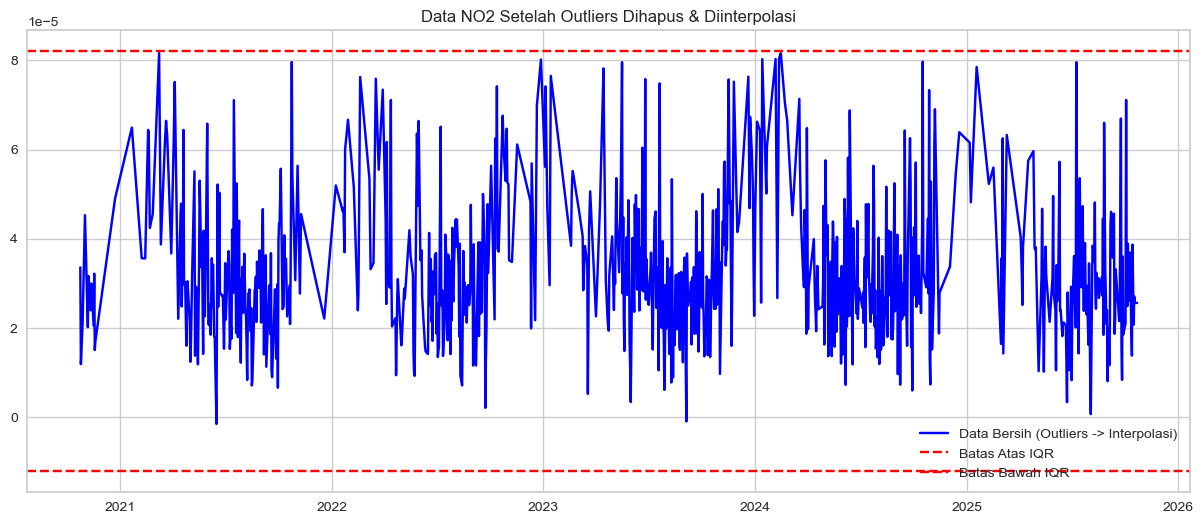

In [11]:
# Cek Missing Values (sekarang bertambah karena outlier jadi NaN + missing value asli)
missing_before_interp = df_clean['NO2'].isnull().sum()
print(f"Total data kosong Sebelum (Asli + Mantan Outliers): {missing_before_interp}")

# --- 3. INTERPOLASI (Mengisi Data Kosong & Mantan Outliers) ---
# Ini sekaligus menjawab request Anda: mengganti data dengan nilai yang wajar (sesuai tetangga)
df_clean['NO2'] = df_clean['NO2'].interpolate(method='time')

missing_after_interp = df_clean['NO2'].isnull().sum()
print(f"Total data kosong Setelah (Asli + Mantan Outliers): {missing_after_interp}")

# --- 4. CEK ULANG (Verifikasi) ---
outliers_after = ((df_clean['NO2'] < lower_bound) | (df_clean['NO2'] > upper_bound)).sum()

print(f"Jumlah Outliers Setelah Pembersihan: {outliers_after}")

# --- VISUALISASI PERBANDINGAN ---
plt.figure(figsize=(15, 6))
# Plot data asli (masih ada outliers/bolong) - kita ambil dari df_fix awal jika mau, atau plot df_clean saja
plt.plot(df_clean.index, df_clean['NO2'], label='Data Bersih (Outliers -> Interpolasi)', color='blue')
# Gambar garis batas
plt.axhline(y=upper_bound, color='red', linestyle='--', label='Batas Atas IQR')
plt.axhline(y=lower_bound, color='red', linestyle='--', label='Batas Bawah IQR')
plt.title("Data NO2 Setelah Outliers Dihapus & Diinterpolasi")
plt.legend()
plt.show()

In [12]:
print(f"Missing Values di df_clean: {df_clean['NO2'].isnull().sum()}")

Missing Values di df_clean: 1


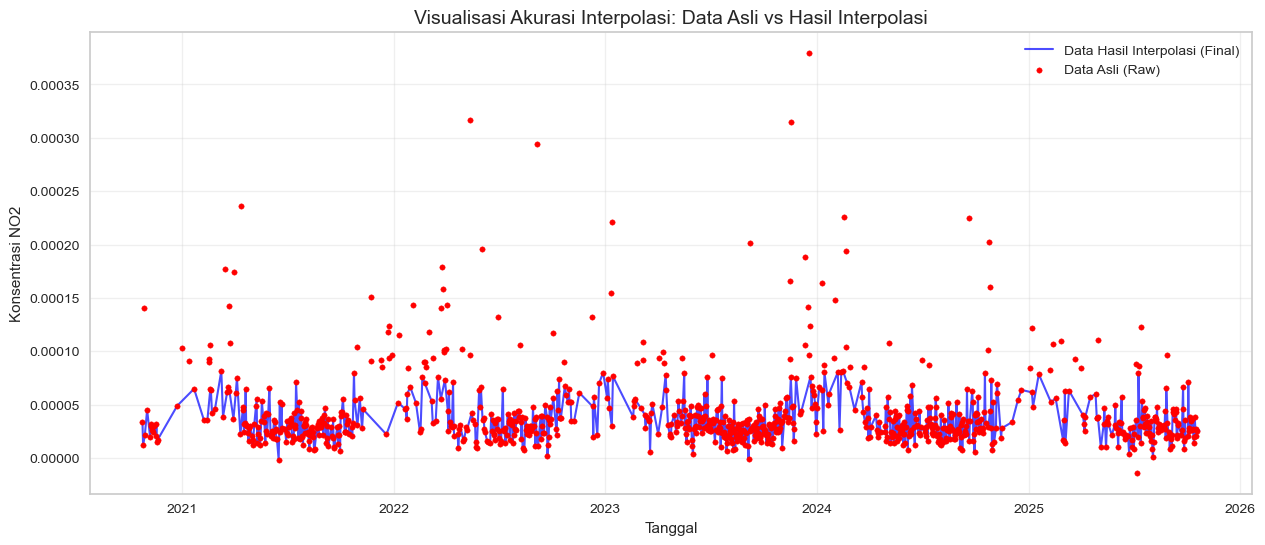

In [13]:
# --- PERSIAPAN DATA ---
# Pastikan kamu masih punya variabel 'df_daily' (data mentah hasil agregasi)
# dan 'df_clean' (data final yang sudah bersih & interpolasi)

plt.figure(figsize=(15, 6))

# 1. Plot Data Hasil Interpolasi (Garis Biru)
# Kita plot ini duluan sebagai 'background'
plt.plot(df_clean.index, df_clean['NO2'], 
         color='blue', linestyle='-', linewidth=1.5, alpha=0.7, 
         label='Data Hasil Interpolasi (Final)')

# 2. Plot Data Asli (Titik Merah)
# Kita gunakan scatter plot (titik-titik) untuk menunjukkan data asli yang bolong-bolong
# Gunakan df_daily yang belum di-apa-apakan (tapi sudah di-agregasi rata-rata harian)
plt.scatter(df_daily.index, df_daily['NO2'], 
            color='red', s=15, zorder=5, 
            label='Data Asli (Raw)')

# --- STYLING ---
plt.title('Visualisasi Akurasi Interpolasi: Data Asli vs Hasil Interpolasi', fontsize=14)
plt.ylabel('Konsentrasi NO2')
plt.xlabel('Tanggal')
plt.legend()
plt.grid(True, alpha=0.3)

# --- FITUR ZOOM (OPSIONAL - PENTING) ---
# Karena data 5 tahun sangat padat, kita perlu zoom ke periode pendek
# agar terlihat jelas bagian mana yang "ditambal" oleh interpolasi.
# Coba uncomment baris di bawah ini untuk melihat detail 3 bulan tertentu:

# plt.xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2021-04-01')) 

plt.show()

### *Split Data Train dan Data Test*

In [15]:
# print(f"Nilai minimum sebelum fix: {df_clean['NO2'].min()}")

# # Clip data: Semua yang di bawah 1e-6 jadi 1e-6
# df_clean['NO2'] = df_clean['NO2'].clip(lower=1e-6)

# print(f"Nilai minimum setelah fix: {df_clean['NO2'].min()}")

Total Data: 1826
Data Training (Latih): 1460 baris
Data Testing (Uji)   : 366 baris

Training berakhir pada: 2024-10-21 00:00:00
Testing dimulai pada  : 2024-10-22 00:00:00


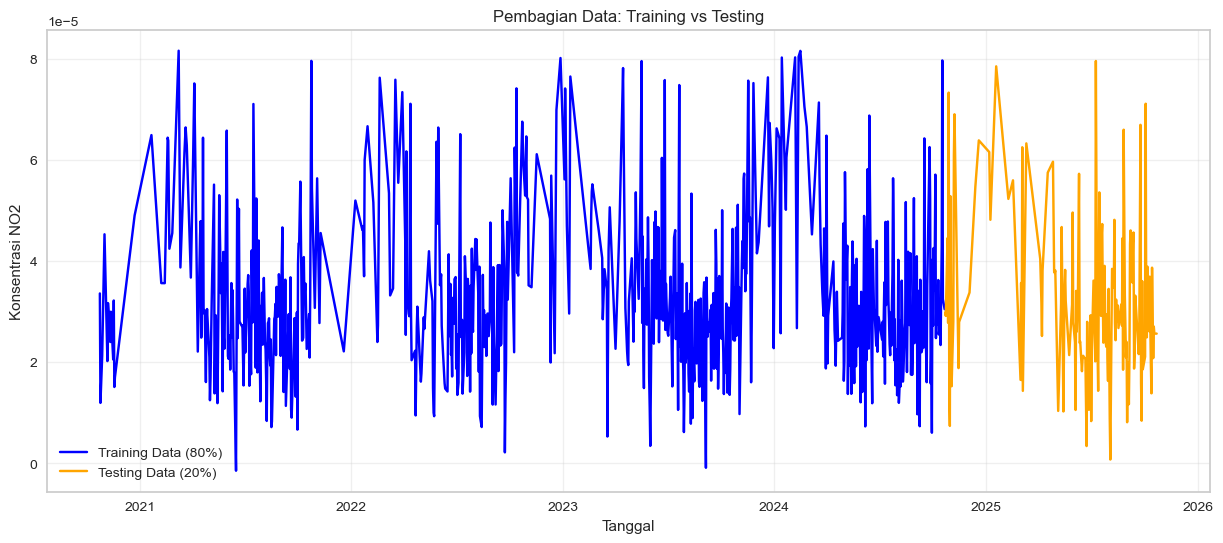

In [16]:
# --- SPLITTING DATA (80% Train : 20% Test) ---

train_size = int(len(df_clean) * 0.8) # 80% Data Awal
train_data = df_clean.iloc[:train_size]
test_data = df_clean.iloc[train_size:]

print(f"Total Data: {len(df_clean)}")
print(f"Data Training (Latih): {len(train_data)} baris")
print(f"Data Testing (Uji)   : {len(test_data)} baris")

# Cek Tanggal Potong
print(f"\nTraining berakhir pada: {train_data.index.max()}")
print(f"Testing dimulai pada  : {test_data.index.min()}")

# --- VISUALISASI PEMBAGIAN ---
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data['NO2'], label='Training Data (80%)', color='blue')
plt.plot(test_data.index, test_data['NO2'], label='Testing Data (20%)', color='orange')

plt.title('Pembagian Data: Training vs Testing')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## **Modeling**

In [17]:
# Cell 1: Handling Missing Value Awal & Nilai Negatif

# 1. TAMBAL DATA PERTAMA & TERAKHIR (PENTING!)
# .bfill() = Mengambil nilai dari depannya (untuk menambal data pertama yang NaN)
# .ffill() = Mengambil nilai dari belakangnya (untuk menambal data terakhir yang NaN)
train_data['NO2'] = train_data['NO2'].bfill().ffill()
test_data['NO2'] = test_data['NO2'].bfill().ffill()

# 2. Handling Nilai Negatif (Fisika)
# Kita ubah nilai < 0 atau 0 menjadi 0.000001
train_data['NO2'] = train_data['NO2'].clip(lower=0.000001)
test_data['NO2'] = test_data['NO2'].clip(lower=0.000001)

# Cek Final (Harusnya 0)
print(f"NaN di Train: {train_data['NO2'].isna().sum()}")
print(f"NaN di Test : {test_data['NO2'].isna().sum()}")
print("Data sudah bersih total.")

NaN di Train: 0
NaN di Test : 0
Data sudah bersih total.


In [18]:
# Cell 2: Training Model
warnings.filterwarnings('ignore') # Biar warning tidak memenuhi layar

# 1. Single Exponential Smoothing (SES)
print("Training SES...")
model_ses = ExponentialSmoothing(train_data['NO2'], trend=None, seasonal=None).fit()
pred_ses = model_ses.forecast(len(test_data))

# 2. Double Exponential Smoothing (DES)
print("Training DES...")
model_des = ExponentialSmoothing(train_data['NO2'], trend='add', seasonal=None).fit()
pred_des = model_des.forecast(len(test_data))

# 3. Triple Exponential Smoothing (TES)
print("Training TES...")
model_tes = ExponentialSmoothing(train_data['NO2'], trend='add', seasonal='add', seasonal_periods=7).fit()
pred_tes = model_tes.forecast(len(test_data))

print("Semua model selesai dilatih ulang.")

Training SES...
Training DES...
Training TES...
Semua model selesai dilatih ulang.


## **Evaluasi**

In [19]:
# Cell 3: Hitung Error & Buat Tabel
def hitung_skor(y_true, y_pred, nama):
    # PENGAMAN EKSTRA:
    # Jika prediksi menghasilkan NaN, ubah jadi 0 (atau angka aman) biar tidak crash
    if np.isnan(y_pred).any():
        print(f"Warning: Model {nama} menghasilkan NaN di prediksi. Diganti otomatis.")
        y_pred = np.nan_to_num(y_pred, nan=0.000001)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return {'Model': nama, 'RMSE': rmse, 'MAPE (%)': mape}

skor = []
# Pastikan y_true juga bersih (ambil dari test_data yang sudah dibersihkan di Cell 1)
y_aktual = test_data['NO2'] 

skor.append(hitung_skor(y_aktual, pred_ses, 'SES'))
skor.append(hitung_skor(y_aktual, pred_des, 'DES'))
skor.append(hitung_skor(y_aktual, pred_tes, 'TES'))

df_hasil = pd.DataFrame(skor)
print("\n=== PERBANDINGAN AKURASI MODEL ===")
print(df_hasil)


=== PERBANDINGAN AKURASI MODEL ===
  Model      RMSE   MAPE (%)
0   SES  0.000019  50.611390
1   DES  0.000020  45.855022
2   TES  0.000028  61.808171


## **Testing Model**

In [20]:
def prediksi_masa_depan_rapi(data, hari_ke_depan=30):
    # 1. PREPROCESSING (PENGAMAN)
    df_safe = data.copy()
    df_safe['NO2'] = df_safe['NO2'].clip(lower=0.000001)
    df_safe['NO2'] = df_safe['NO2'].bfill().ffill()
    df_safe = df_safe.asfreq('D')
    df_safe['NO2'] = df_safe['NO2'].interpolate(method='time')
    
    # 2. TRAINING MODEL
    model = ExponentialSmoothing(
        df_safe['NO2'], 
        trend='add', 
        seasonal='mul', 
        seasonal_periods=7
    )
    model_fit = model.fit()
    
    # 3. FORECASTING
    forecast_values = model_fit.forecast(hari_ke_depan)
    
    # --- TRIK 1: MENYAMBUNGKAN GARIS (FIX GAP) ---
    # Kita ambil titik terakhir dari data asli
    last_date = df_safe.index[-1]
    last_value = df_safe['NO2'].iloc[-1]
    
    # Buat Series baru untuk prediksi yang diawali titik terakhir data asli
    # Ini membuat garisnya "nempel" secara fisik
    forecast_index = [last_date] + list(forecast_values.index)
    forecast_data = [last_value] + list(forecast_values.values)
    
    series_forecast = pd.Series(forecast_data, index=forecast_index)

    # --- TRIK 2: INTERVAL KEPERCAYAAN (AGAR LEBIH NATURAL) ---
    # Kita hitung standar deviasi error dari masa lalu
    std_error = model_fit.resid.std()
    
    # Buat batas atas dan bawah (Simulasi volatilitas)
    # 1.96 adalah standar untuk confidence interval 95%
    upper_bound = series_forecast + (1.96 * std_error)
    lower_bound = series_forecast - (1.96 * std_error)
    # Pastikan batas bawah tidak negatif
    lower_bound = lower_bound.clip(lower=0) 

    return df_safe, series_forecast, lower_bound, upper_bound


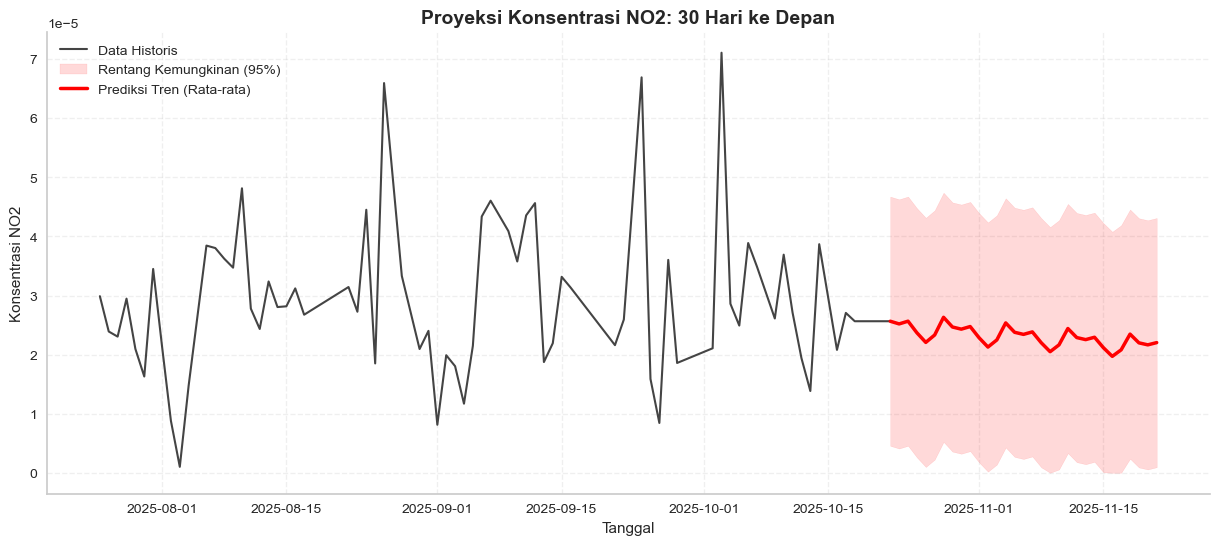

In [21]:
# --- EKSEKUSI VISUALISASI ---

# Panggil fungsi baru
data_aman, hasil_prediksi, batas_bawah, batas_atas = prediksi_masa_depan_rapi(df_clean, hari_ke_depan=30)

# Tampilkan Grafik
plt.figure(figsize=(15, 6))

# 1. Plot Data Historis (90 Hari Terakhir) - Warna Abu Gelap
data_terakhir = data_aman.tail(90)
plt.plot(data_terakhir.index, data_terakhir['NO2'], 
         label='Data Historis', color='#444444', linewidth=1.5)

# 2. Plot Area Arsiran (Confidence Interval) - INI KUNCINYA
# Ini mengisi ruang kosong dan membuat grafik terlihat lebih "berisi" dan natural
plt.fill_between(hasil_prediksi.index, batas_bawah, batas_atas, 
                 color='red', alpha=0.15, label='Rentang Kemungkinan (95%)')

# 3. Plot Garis Prediksi Utama (Tebal & Menyambung)
plt.plot(hasil_prediksi.index, hasil_prediksi, 
         label='Prediksi Tren (Rata-rata)', color='red', linewidth=2.5)

# Kosmetik Grafik
plt.title('Proyeksi Konsentrasi NO2: 30 Hari ke Depan', fontsize=14, fontweight='bold')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO2')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3, linestyle='--')

# Hapus border atas dan kanan biar lebih modern (mirip jurnal)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Data Siap. Train: 1460, Test: 366

[1/3] Training Statsmodels (Manual)...

[2/3] Training PyCaret...
-> Model: Exponential Smoothing ('exp_smooth')
-> Prediksi PyCaret berhasil dibuat.

[3/3] Plotting Grafik...


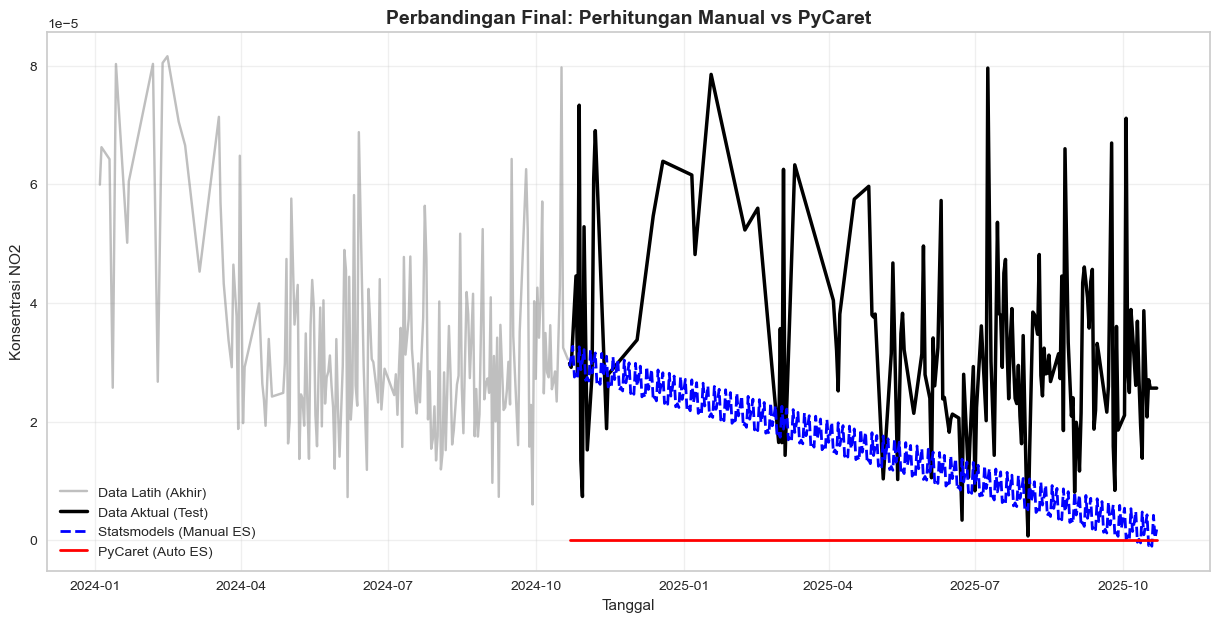


=== KESIMPULAN AKURASI (RMSE) ===
1. Statsmodels (Manual) : 0.000028
2. PyCaret (Otomatis)   : 0.000043

KESIMPULAN: Perhitungan manual Statsmodels memberikan hasil yang lebih akurat.


In [32]:
# ==============================================================================
# KODE FINAL: PERBANDINGAN (DENGAN AUTO-FIX MODEL SELECTION)
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pycaret.time_series import *
from sklearn.metrics import mean_squared_error

# --- 1. PEMBERSIHAN DATA ---
# Kita pastikan data bersih dan indexnya benar
df_final = df_clean.copy()
if not pd.api.types.is_datetime64_any_dtype(df_final.index):
    df_final.index = pd.to_datetime(df_final.index)
df_final = df_final.asfreq('D') # Paksa harian
df_final['NO2'] = df_final['NO2'].interpolate(method='linear') # Isi bolong tengah
df_final['NO2'] = df_final['NO2'].bfill().ffill() # Isi bolong ujung
df_final['NO2'] = df_final['NO2'].fillna(0.000001) # Jaga-jaga

# Split
train_size = int(len(df_final) * 0.8)
train_data = df_final.iloc[:train_size]
test_data = df_final.iloc[train_size:]
print(f"Data Siap. Train: {len(train_data)}, Test: {len(test_data)}")

# --- 2. STATSMODELS (MANUAL) ---
print("\n[1/3] Training Statsmodels (Manual)...")
try:
    model_sm = ExponentialSmoothing(train_data['NO2'], trend='add', seasonal='add', seasonal_periods=7).fit()
    pred_sm = model_sm.forecast(len(test_data))
    pred_sm = pd.Series(pred_sm.values, index=test_data.index)
except:
    pred_sm = pd.Series([np.nan]*len(test_data), index=test_data.index)

# ==============================================================================
# KODE PYCARET & VISUALISASI (VERSI ANTI-INDEX ERROR)
# ==============================================================================

# --- 3. PYCARET (OTOMATIS) ---
print("\n[2/3] Training PyCaret...")
pred_pc = None

try:
    # Reset index agar PyCaret membaca tanggal sebagai kolom biasa
    df_train_reset = train_data.reset_index()
    df_train_reset.columns = ['Tanggal', 'NO2']
    
    # Setup (Hanya gunakan data latih untuk training)
    s = setup(data = df_train_reset, target = 'NO2', index = 'Tanggal', 
              fh = len(test_data), fold = 2, session_id = 123, verbose = False)
    
    # Pilih model (Coba 'exp_smooth' dulu, kalau gagal baru 'theta')
    try:
        model_pc = create_model('exp_smooth', verbose=False)
        print("-> Model: Exponential Smoothing ('exp_smooth')")
    except:
        model_pc = create_model('theta', verbose=False)
        print("-> Model: Theta Forecaster")

    # Finalisasi & Prediksi
    final_pc = finalize_model(model_pc)
    
    # Prediksi ke masa depan (sepanjang len(test_data))
    # PyCaret akan memprediksi 'fh' periode ke depan dari titik terakhir data training
    pred_pc_df = predict_model(final_pc)
    
    # --- BAGIAN PENTING: AMBIL HASIL PREDIKSI TANPA NAMA KOLOM ---
    # Kita ambil kolom terakhir, karena di PyCaret kolom prediksi SELALU di posisi terakhir
    pred_values = pred_pc_df.iloc[:, -1].values 
    
    # Buat Series baru dengan index yang benar (menggunakan tanggal dari data test)
    pred_pc = pd.Series(pred_values, index=test_data.index)
    
    print("-> Prediksi PyCaret berhasil dibuat.")

except Exception as e:
    print(f"Masih Error di PyCaret: {e}")
    # Tampilkan detail kolom jika ada error, untuk debugging
    try: print(f"Kolom yang ada: {pred_pc_df.columns.tolist()}")
    except: pass


# --- 4. VISUALISASI HASIL AKHIR ---
print("\n[3/3] Plotting Grafik...")
plt.figure(figsize=(15, 7))

# Zoom 20% data terakhir dari Training
zoom_start = int(len(train_data) * 0.8)
plt.plot(train_data.index[zoom_start:], train_data['NO2'].iloc[zoom_start:], 
         label='Data Latih (Akhir)', color='gray', alpha=0.5)

# Data Test (Aktual)
plt.plot(test_data.index, test_data['NO2'], 
         label='Data Aktual (Test)', color='black', linewidth=2.5)

# Prediksi Manual (Statsmodels)
if not pred_sm.isna().all():
    plt.plot(pred_sm.index, pred_sm, label='Statsmodels (Manual ES)', color='blue', linestyle='--', linewidth=2)

# Prediksi Otomatis (PyCaret)
if pred_pc is not None:
    plt.plot(pred_pc.index, pred_pc, label='PyCaret (Auto ES)', color='red', linestyle='-', linewidth=2)

plt.title('Perbandingan Final: Perhitungan Manual vs PyCaret', fontsize=14, fontweight='bold')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 5. KESIMPULAN OTOMATIS ---
if pred_pc is not None and not pred_sm.isna().all():
    rmse_sm = np.sqrt(mean_squared_error(test_data['NO2'], pred_sm))
    rmse_pc = np.sqrt(mean_squared_error(test_data['NO2'], pred_pc))
    
    print(f"\n=== KESIMPULAN AKURASI (RMSE) ===")
    print(f"1. Statsmodels (Manual) : {rmse_sm:.6f}")
    print(f"2. PyCaret (Otomatis)   : {rmse_pc:.6f}")
    
    if rmse_pc < rmse_sm:
        print("\nKESIMPULAN: PyCaret memberikan hasil yang lebih akurat.")
    else:
        print("\nKESIMPULAN: Perhitungan manual Statsmodels memberikan hasil yang lebih akurat.")